## Multilayer Perceptron (MLP)

Multi-class classification problem - using a MLP with configurable number of hidden neurons - with a configurable number of classes (up to 10). It selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a classifier using softmax.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#only at first execution data is downloaded, because it is saved in subfolder ../week1/data; 
#note the relative path to the 01.learning-optimization to avoid multiple downloads
data_set = 'FashionMNIST'
    
if data_set == 'FahsionMNIST':
    training_data = torchvision.datasets.MNIST(
        root="../01.learning-optimization/data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root="../01.learning-optimization/data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )    

    #labels for MNIST (just for compatibility reasons)
    labels_map = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
else:
    training_data = torchvision.datasets.FashionMNIST(
        root="../01.learning-optimization/data",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root="../01.learning-optimization/data",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    #labels for FashionMNIST
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

In [3]:
#convert to numpy array (originally it is a torch.tensor)
x = training_data.data.numpy()
x = np.append(x, test_data.data.numpy(),0)

y = training_data.targets.numpy()
y = np.append(y, test_data.targets.numpy())

print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


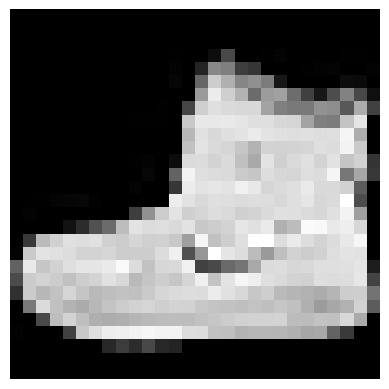

In [4]:
def plot_img(img):
    """
    plot a single mnist image
    """
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
plot_img(x[0])

In [5]:
def plot_tiles(x_array, rows, cols = -1, fig_size = [10,10]):
    """
    plot list of images as single image

    Arguments:
    x_array -- array of images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - images is created (if x_array is smaller zeros ared padded)
    fig_size -- size of full image created (default [10,10])
    """

    digit_size = 28 #size of digit (width = height)
    
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

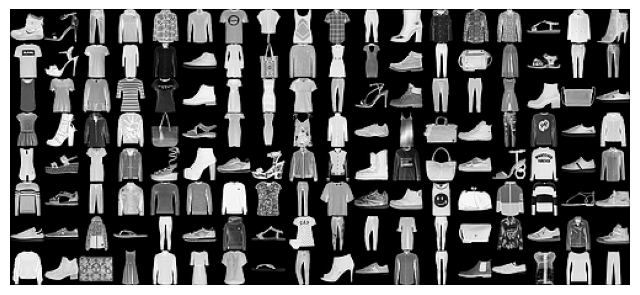

In [6]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]

plot_tiles(x, rows, cols, fig_size)

T-Shirt


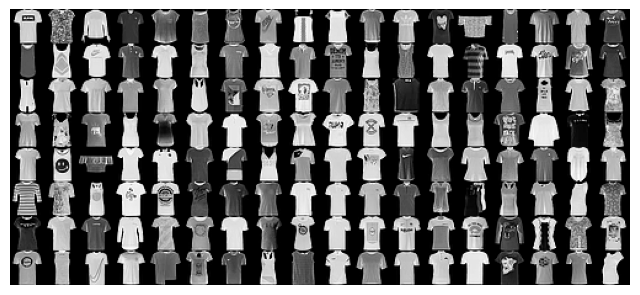

In [7]:
#choose a given class 0..9
digit  = 0

plot_tiles(x[y == digit,:], rows, cols, fig_size)
print(labels_map[digit])

In [8]:
#select the classes for your training and test set, select train and test split and to normalization
def prepare_data(classes, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    classes -- list of classes to use for training (at least two classes must be given)
    train_size -- fraction of train image size
    min_max_normalise -- whether to do min-max-normalisation (1) or rescaling (0)
    flatten -- whether to flatten the 28x28 image to single row (=1); otherwise a new dimension is added at axis=1 (to be compatible with cnn)
    """

    if len(classes) < len(labels_map):
        for label in classes:
            print('labels chosen are: %r' % labels_map[label])

    ind_sel = np.isin(y, classes)
    x_sel = x[ind_sel,:].copy()
    y_sel = y[ind_sel].copy()

    #replace the labels such that they are in successive order
    for i0 in range(0,len(classes)):
        if i0 != classes[i0]:
            y_sel[y_sel == classes[i0]] = i0

    #we give y back as simple vector -> simplifies handling below
    #y_sel = np.reshape(y_sel, (-1,1))
    
    #do train and test split
    num_samples = x_sel.shape[0]
    max_train_ind = int(train_size*num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    x_train = x_sel[indices[:max_train_ind]]
    x_test = x_sel[indices[max_train_ind:]]
    
    y_train = y_sel[indices[:max_train_ind]]
    y_test = y_sel[indices[max_train_ind:]]

    #perform normalisation, take care of converting data type to float!
    xmax, xmin = np.max(x_train), np.min(x_train)
    
    if min_max_normalise:
        x_train = 2*(x_train.astype(float) - xmin) / (xmax - xmin) - 1
        x_test = 2*(x_test.astype(float) - xmin) / (xmax - xmin) - 1
    else:
        x_train = x_train.astype(float) / xmax 
        x_test = x_test.astype(float) / xmax 

    if flatten:
        m = x_train.shape[0]
        x_train = x_train.reshape([m,-1])
        m = x_test.shape[0]
        x_test = x_test.reshape([m,-1])
    
    return x_train, x_test, y_train, y_test

### Class MiniBatches

Splits the given dataset (`x: features` and `y: labels`) into individual batches of size `batch_size` (a value of `0` will return the full batch). The total number of batches available in an epoch is returned with method `number_of_batches()`. Each call to `next()` will return a new batch in the given format: `{'x_batch': x_batch, 'y_batch': y_batch}`

In [9]:
class MiniBatches:
    """
    split set into batches

    Arguments:
    x -- features
    y -- corresponding labels
    batch_size -- size of batches
    """
    

    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}

### DropoutLayer
Implementation of class for dropout layer with given dropout probability

In [10]:
class DropoutLayer:
    """
    constructs a dropout layer with given dropout probability
    """
    def __init__(self, size_in, drop_p = 0.5):
        """
        constructor
        
        Arguments:
        size_in -- number of inputs (i.e. of neurons from previous layer); equals number of outputs
        drop_p -- dropout probability
        """
        self.size_in = size_in
        self.size_out = size_in
        self.drop_p = drop_p;
    
    
    def set_dropout_vector(self, len_v):
        """
        calculates a vector of 0/1 with length len_v for dropout of current step
        fraction of 0 should be equal to self.drop_p; ordering random
        """
### START YOUR CODE ###  
        prob = self.drop_p          
        #self.drop_out = np.random.choice([0,1], len_v, p=[prob, 1-prob])
        number_of_zeros = int(len_v*prob)
        self.drop_out = np.ones(len_v)
        self.drop_out[:number_of_zeros] = 0
        np.random.shuffle(self.drop_out)
### END YOUR CODE ###            
        
        return
    
    
    def propagate(self, a_in, learn = False):
        """
        applies dropout
        """    
        if a_in.shape[1] != self.size_in:
            print('warning: size %r does not correspond to initialisation %r' % (a_in.shape[1], self.size_in))
        
        self.a_out = a_in
        #apply dropout
        if learn:
            self.set_dropout_vector(self.a_out.shape[1])
            self.a_out = self.a_out*self.drop_out/(1-self.drop_p) #broadcast
        
        return self.a_out
            
     
    def back_propagate(self, dL_da_out):
        """
        applies dropout
        """    
### START YOUR CODE ###             
        #apply dropout in backward path
        self.dL_da_in = dL_da_out*self.drop_out 
### END YOUR CODE ###     
        
        return self.dL_da_in
    
    def gradient_descend(self, alpha):
        """
        dummy implementation to satisfy interface
        """
        return

### DenseLayer¶

Implementation of class for dense layer of MLP with sigmoid activation function. This class is used by the class NeuralNetwork below.

In [11]:
class DenseLayer:
    """
    constructs a dense layer with for a MLP
    """
    def __init__(self, size_in, size_out, activation = 'sigmoid', regularize = 0):
        """
        constructor

        Arguments:
        size_in -- number of inputs (i.e. of neurons from previous layer)
        size_out -- number of outputs (i.e. of neurons in this layer) 
        regularize -- L2 regularisation factor
        """
        
        self.size_in = size_in
        self.size_out = size_out
        self.activation = activation
        self.regularize = regularize

        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    def initialise_weights(self):
        """
        initialize weights and bias with Glorot or He scheme
        """ 
### START YOUR CODE ###        
        #correct scaling for given activation function
        if self.activation == 'sigmoid':
            random_std_W = 0    
        if self.activation == 'tanh':
            random_std_W = 0   
        if self.activation == 'relu':
            random_std_W = 0     
### END YOUR CODE ###        
        
        self.W = random_std_W * 2*(np.random.rand(self.size_in, self.size_out)-0.5)  
        random_std_B = 0 #set to zero
        self.B = random_std_B * 2*(np.random.rand(1, self.size_out)-0.5)
        
              
    def propagate(self, a_in, learn = False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        self.Z = a_in @ self.W + self.B
        self.a_out = self.activation_function(self.Z)
        
        return self.a_out

    
    def activation_function(self, z):
        """
        apply activation function
        """
        if self.activation == 'sigmoid':
            return 1/(1+np.exp(-z))
### START YOUR CODE ###            
        if self.activation == 'tanh':
            return np.tanh(z)
        if self.activation == 'relu':
            return np.maximum(0, z)
### END YOUR CODE ###    
    
    def d_activation_function(self, z):
        """
        calculates the derivative of the activation function
        """
        if self.activation == 'sigmoid':
            return self.activation_function(z)*(1 - self.activation_function(z))
### START YOUR CODE ###            
        if self.activation == 'tanh':
            return 1. - np.tanh(z)**2
        if self.activation == 'relu':
            return (z > 0).astype(float)
### END YOUR CODE ###           
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """    
        dL_dz = dL_da_out*self.d_activation_function(self.Z)
        self.dL_dW = (self.a_in.T @ dL_dz) / self.num_samples #number of samples from previous prop step
        self.dL_dB = np.sum(dL_dz, 0, keepdims=True) / self.num_samples
        dL_da_in = dL_dz @ self.W.T
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
### START YOUR CODE ###        
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
### END YOUR CODE ###
        

### SoftmaxLayer
Implementation of class for softmax layer of MultiLayerPerceptron below. This class is used by the class NeuralNetwork below

In [12]:
class SoftmaxLayer:
    """
    constructs a sofmax layer for output of a MLP
    """
    
    def __init__(self, size_in, size_out, activation = 'sigmoid', regularize = 0):
        """
        constructor

        Arguments:
        size_in -- number of inputs from previous layer
        size_out -- number of neurons i.e. if outputs
        regularize -- L2 regularisation factor
        """
        
        self.size_in = size_in
        self.size_out = size_out
        self.activation = activation
        self.regularize = regularize
         
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    
    def initialise_weights(self):
        """
        initialize weights and bias with Glorot or He scheme (we use sigmoid scheme because it is closest)
        """ 
        random_std_W = 4*np.sqrt(6.0/(self.size_in + self.size_out)) # suited for sigmod activation function     
        random_std_B = 0 #in case we want to introduce a bias

        self.W = random_std_W * 2*(np.random.rand(self.size_in, self.size_out)-0.5)    
        self.B = random_std_B * 2*(np.random.rand(1, self.size_out)-0.5)
        
        
    def propagate(self, a_in, learn = False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        self.Z = a_in @ self.W + self.B

        #clip large values
        max_val = 700.
        self.Z = np.clip(self.Z, -max_val, max_val)
            
        exp_Z = np.exp(self.Z)
        self.y_pred = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        
        return self.y_pred
    
    
    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, self.size_out), dtype=float)
        one_hot[np.arange(m), y] = 1

        return one_hot
            
     
    def back_propagate(self, y):
        """
        calculates the backpropagation results based on expected output y
        this function must be performed AFTER the corresponding propagte step
        """    
        dL_dz = self.y_pred - self.one_hot(y)
            
        self.dL_dW = (self.a_in.T @ dL_dz) / self.num_samples #number of samples from previous prop step
        self.dL_dB = np.sum(dL_dz, 0, keepdims=True) / self.num_samples
        dL_da_in = dL_dz @ self.W.T
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
### START YOUR CODE ###        
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
### END YOUR CODE ###
        

### Class NeuralNetwork

This class constructs a Multilayer Perceptron with a configurable number of hidden layers. Cost function is CE. The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias for all layers) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$ for all layers.

In [13]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    
    def __init__(self, list_num_neurons, activation = 'sigmoid', regularize = 0, drop_p = 0):
        """
        constructor

        Arguments:
        list_num_neurons -- list of neurons including in- and output layers
        regularize -- L2 regularisation parameter
        """
        self.layers = []
        #first construct dense layers (if any)
        for i0 in range(len(list_num_neurons)-2):
            if drop_p > 0: #add dropout layer
                new_layer = DropoutLayer(list_num_neurons[i0], drop_p)
                self.layers.append(new_layer)
                
            new_layer = DenseLayer(list_num_neurons[i0], list_num_neurons[i0+1], activation, regularize)
            self.layers.append(new_layer)

        if drop_p > 0: #add final dropout layer
            new_layer = DropoutLayer(list_num_neurons[-2], drop_p)
            self.layers.append(new_layer)
        
        #finally add softmax layer
        new_layer = SoftmaxLayer(list_num_neurons[-2], list_num_neurons[-1], activation, regularize)
        self.layers.append(new_layer)

        # result array
        self.result_data = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 

    
    def propagate(self, x, learn = False):
        """
        calls successively propagate methods of all layers 
        result of each layer is passed to next layer
        dropout layer requires knowledge about learning or not
        """
        for layers in self.layers:
            x = layers.propagate(x, learn = learn)
            
        return x

     
    def back_propagate(self, y):
        """
        calls successively back_propagate methods of all layers 
        result of each layer is passed to next layer
        """
        #first do softmax with y as input
        dL_da_out = y
        #now the remaining layers
        for i0 in reversed(range(len(self.layers))):
            dL_da_out = self.layers[i0].back_propagate(dL_da_out)
            
        return dL_da_out
    
    
    def gradient_descend(self, alpha):
        """
        calls successively gradient_descend methods of all layers 
        """
        for layers in self.layers:
            layers.gradient_descend(alpha)  
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        y_pred_argmax = np.argmax(y_pred, axis=1)
        error = np.sum(y != y_pred_argmax) / m

        return error


    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, self.size_out), dtype=float)
        one_hot[np.arange(m), y] = 1

        return one_hot
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function
        """
        m = y.shape[0]
        
        #take care of possible over over or underflow
        eps=1.0e-12
        y_pred = np.clip(y_pred,eps,1-eps)
        py = y_pred[np.arange(m), y]
        cost = -np.sum(np.log(py)) / m
        
        return cost   
    
    
    def append_result(self):
        """
        append cost and error data to output array
        """
        # determine cost and error functions for train and validation data
        y_pred_train = self.propagate(self.data['x_train'])
        y_pred_val = self.propagate(self.data['x_val'])

        res_data = np.array([[self.cost_funct(y_pred_train, self.data['y_train']), 
                              self.calc_error(y_pred_train, self.data['y_train']),
                              self.cost_funct(y_pred_val, self.data['y_val']), 
                              self.calc_error(y_pred_val, self.data['y_val'])]])
        
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        #increase epoch counter here (used for plot routines below)
        self.epoch_counter += 1 
        
        return res_data


    def print_layers(self):
        ind = 1
        for layers in self.layers:
            print('layer [%r] is %r' % (ind, layers.__class__.__name__))
            print('#input is %r, #output is %r' % (layers.size_in, layers.size_out))
            if layers.__class__.__name__ == 'DropoutLayer':
                print('dropout rate is %r\n' % layers.drop_p)
            else:                
                print('activation function is %r' % layers.activation)
                print('regularisation is %r\n' % layers.regularize)
            ind += 1
          
    def optimise(self, data, epochs, alpha, batch_size=0, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        batch_size -- size of batches (1 = SGD, 0 = batch, 1 < .. < n = mini-batch)
        debug -- integer value; get info on gradient descend step every debug-step (0 -> no output)
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.append_result()

        for i0 in range(0, epochs):    
            # create batches for each epoch
            batches = MiniBatches(self.data['x_train'], self.data['y_train'], batch_size)

            for ib in range(batches.number_of_batches()):
                batch = batches.next()
            
                y_pred = self.propagate(batch['x_batch'], learn = True)
                self.back_propagate(batch['y_batch'])
                self.gradient_descend(alpha)
          
            res_data = self.append_result()
                      
            if debug and np.mod(i0, debug) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                                          % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))

        if debug:
            print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                  % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))
    

In [14]:
def plot_error(nn_instance):
    """
    analyse error as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_error = nn_instance.result_data[:,1]
    val_error = nn_instance.result_data[:,3]

    plt.semilogy(epochs, train_error, label="train")
    plt.semilogy(epochs, val_error, label="validation")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 1e-3
    ymax = 5e-1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

In [15]:
def plot_cost(nn_instance):
    """
    analyse cost as function of epochs

    Arguments:
    nn_instance -- NeuralNetwork class to plot
    """
    epochs = np.arange(nn_instance.epoch_counter)
    train_costs = nn_instance.result_data[:,0]
    val_costs = nn_instance.result_data[:,2]

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="validation")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 1e-2
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

In [16]:
def plot_parameter_hist(nn_inst, num_bins = 50, fig_size=[10,5]):
    """
    plots the parameter distribution (weights and biases) for all layers as histogram
    """      
    for layer in nn_inst.layers:
        if layer.__class__.__name__ == 'DenseLayer' or layer.__class__.__name__ == 'SoftmaxLayer':
            fig, axs = plt.subplots(1, 2, figsize=fig_size)
            key = layer.__class__.__name__
    
            weight =layer.W.reshape(-1)
            bias = layer.B.reshape(-1)
            # We can set the number of bins with the *bins* keyword argument.
            axs[0].hist(weight, bins=num_bins)
            axs[0].set_title(key + ' - weights')
            axs[0].set_ylabel('count')
            axs[0].set_xlabel('value')
            axs[1].hist(bias, bins=num_bins)
            axs[1].set_title(key + ' - biases')
            axs[1].set_ylabel('count (bias)')
            axs[1].set_xlabel('value')
    
        plt.show()

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. The classes (from 2 to 10) can be chosen via the `classes` list. This method can be called several times in a row with different arguments.

layer [1] is 'DenseLayer'
#input is 784, #output is 200
activation function is 'sigmoid'
regularisation is 0.0

layer [2] is 'DenseLayer'
#input is 200, #output is 100
activation function is 'sigmoid'
regularisation is 0.0

layer [3] is 'SoftmaxLayer'
#input is 100, #output is 10
activation function is 'sigmoid'
regularisation is 0.0

result after 1 epochs, train: cost 1.31318, error 0.56971 ; validation: cost 1.31561, error 0.57027
result after 6 epochs, train: cost 0.61051, error 0.21859 ; validation: cost 0.61620, error 0.21777
result after 11 epochs, train: cost 0.52387, error 0.18554 ; validation: cost 0.54630, error 0.18875
result after 16 epochs, train: cost 0.51262, error 0.17958 ; validation: cost 0.53996, error 0.18777
result after 21 epochs, train: cost 0.49732, error 0.17670 ; validation: cost 0.52775, error 0.18482
result after 26 epochs, train: cost 0.51944, error 0.18688 ; validation: cost 0.56113, error 0.20080
result after 31 epochs, train: cost 0.50833, error 0.18257 

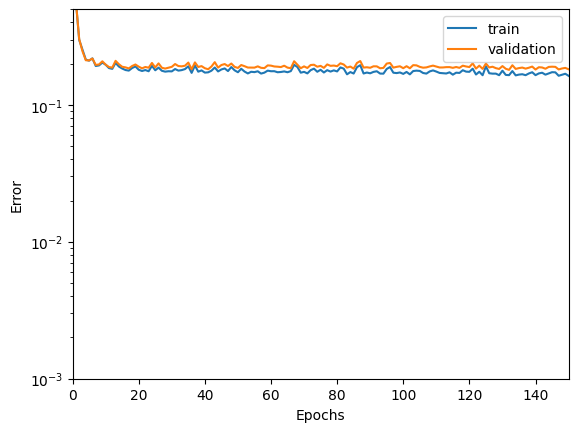

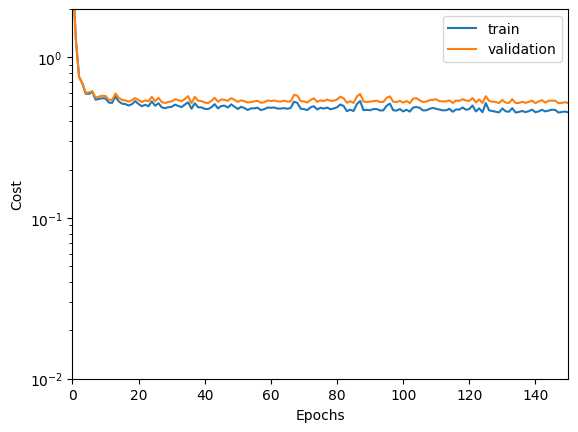

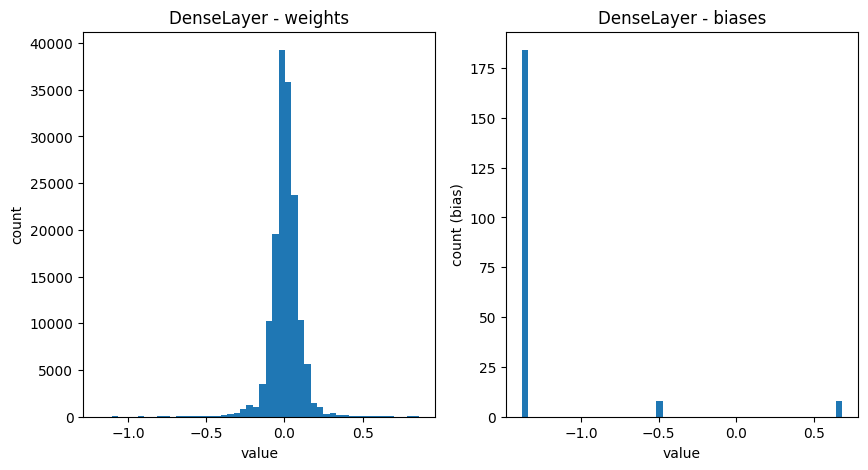

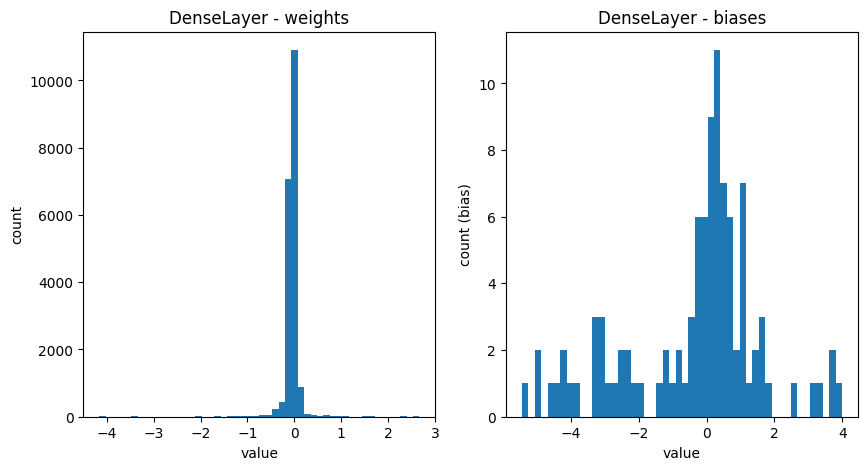

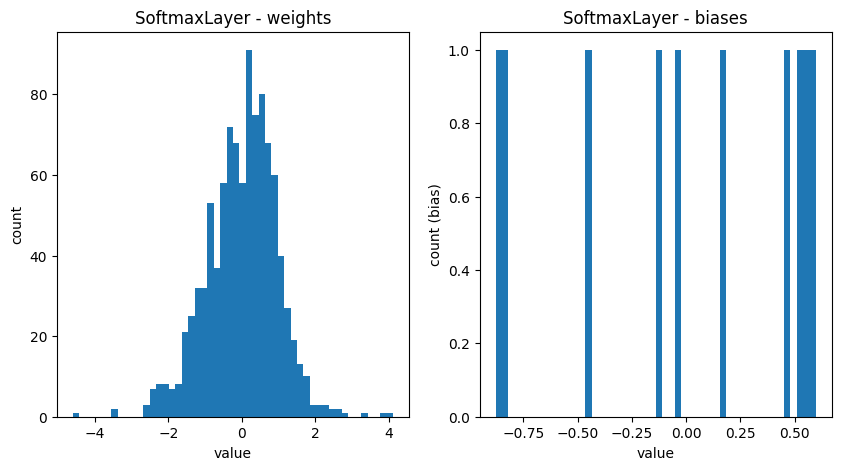

test error rate: 17.76 % out of 14000
(2486, 784)


In [17]:
#choose the categories
classes = [0,1,2,3,4,5,6,7,8,9]

x_train, x_test, y_train, y_test = prepare_data(classes, train_size=0.8, min_max_normalise=0, flatten=1)

#further split in train and validation data
validation_size = 0.2
valid_ind = int(x_train.shape[0]*(1-validation_size))

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train[:valid_ind,:], 'y_train' : y_train[:valid_ind],  \
               'x_val' : x_train[valid_ind:,:], 'y_val' : y_train[valid_ind:]}

#choose the hyperparameters you want to use for the initialisation
size_in = x_train.shape[1]
size_out = len(classes)
list_num_neurons = [size_in, 200, 100, size_out]; 
NNet = NeuralNetwork(list_num_neurons, activation = 'sigmoid', regularize = 0.0, drop_p = 0.0)

NNet.print_layers()

#choose the hyperparameters you want to use for training
epochs = 150
batchsize = 16
learning_rate = 0.1
NNet.optimise(data, epochs, learning_rate, batchsize, debug=5)


plot_error(NNet)
plot_cost(NNet)

plot_parameter_hist(NNet)

y_pred = np.argmax(NNet.propagate(x_test), axis=1)
false_classifications = x_test[(y_pred != y_test)]

print('test error rate: %.2f %% out of %d' % (100*false_classifications.shape[0]/y_pred.shape[0], y_pred.shape[0]))
print(false_classifications.shape)

test error rate: 17.76 % out of 14000
(2486, 784)
[[0 7 4 6 1 5 6 2]
 [4 5 8 0 2 4 6 5]
 [4 4 7 2 6 4 7 2]
 [1 0 3 0 4 5 6 6]
 [5 2 6 4 2 6 6 8]
 [6 6 2 6 9 6 2 0]
 [4 5 2 2 5 8 4 4]]


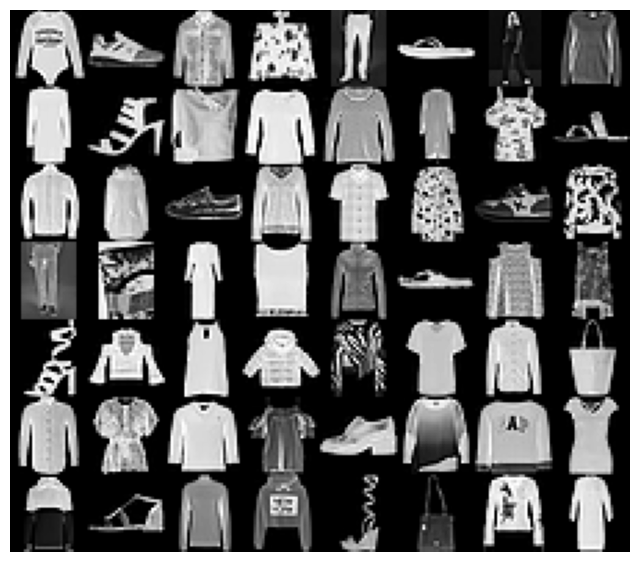

In [18]:
#analyse false classified training or test images
y_pred = np.argmax(NNet.propagate(x_test), axis=1)
false_classifications = x_test[(y_pred != y_test)]

print('test error rate: %.2f %% out of %d' % (100*false_classifications.shape[0]/y_pred.shape[0], y_pred.shape[0]))
print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 7
cols = 8
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications, rows, cols, fig_size)

#print the correct labels (for FashionMNIST)
if rows*cols < false_classifications.shape[0]:
    false_classifications_y = y_test[y_pred != y_test][:rows*cols]
else:
    false_classifications_y = np.append(y_test[y_pred != y_test], np.ones(rows*cols - false_classifications.shape[0])*-1)
print(false_classifications_y.reshape([cols,rows]).T.astype(int))

we have 200 weight vectors in layer [0]
choose a suitable combination of rows and cols below to plot them


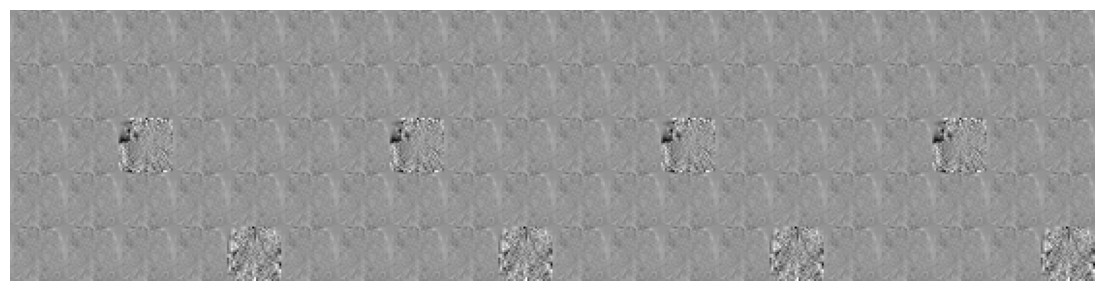

In [19]:
#visualise weights of the first layer

#search first dense layer
found = False
ind = 0
while not found and ind < len(NNet.layers):
    if NNet.layers[ind].__class__.__name__ == 'DenseLayer':
        found = True
        firstDense = ind
    ind += 1

        
print('we have %r weight vectors in layer [%r]' % (NNet.layers[firstDense].W.shape[1], firstDense))
print('choose a suitable combination of rows and cols below to plot them')

rows = 5
cols = 20
#figure size can be set
fig_size = [14,6]

plot_tiles(NNet.layers[firstDense].W.T, rows, cols, fig_size)

# Tests
### Test analytical value of derivative using backpropagation through comparison with difference quotient (does not work for Dropout layers!!)¶

In [20]:
#define set of m dummy samples with num_features features each being N(0,1) normalised
num_features = 50
m = 3
num_outcomes = 4
x_0 = np.random.randn(m, num_features)
y_0 = np.random.randint(0,num_outcomes,size=m)

#create a dummy MLP; num of input and output layers is fixed, hidden layers can be configured
NNet = NeuralNetwork([num_features, 50, 40, 30,num_outcomes], activation = 'sigmoid', regularize = 0.0)

NNet.print_layers()

#do propagation and backpropagation
y_pred = NNet.propagate(x_0)
dL_x = NNet.back_propagate(y_0)

L = NNet.cost_funct(y_pred, y_0)

#apply eps to given layer
eps = 1.0e-8
#maximum allowed difference
max_diff = 4.0e-7

#loop over all layers
layer_ind = 0
for layer in NNet.layers:
    print('test weights W for layer %r' % layer_ind)
    #loop over all weights in layer
    for i0 in range(layer.W.shape[0]):
        for i1 in range(layer.W.shape[1]):
            #add eps to weight
            layer.W[i0,i1] += eps
            #do propagation
            y_pred = NNet.propagate(x_0)
            #determine new cost function and ...
            L_eps = NNet.cost_funct(y_pred, y_0)
            #determine approx. derivative
            dL = (L_eps-L)/eps

            #compare this value to result from backpropagation
            if np.abs(dL - layer.dL_dW[i0,i1]) > max_diff:
                print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dW[i0,i1]))

            #set value back to original value
            layer.W[i0,i1] -= eps

    print('test bias B for layer %r' % layer_ind)
    #loop over all bias values in layer
    for i1 in range(layer.B.shape[1]):
        #add eps to weight
        layer.B[0,i1] += eps
        #do propagation
        y_pred = NNet.propagate(x_0)
        #determine new cost function and ...
        L_eps = NNet.cost_funct(y_pred, y_0)
        #determine approx. derivative
        dL = (L_eps-L)/eps

        #compare this value to result from backpropagation
        if np.abs(dL - layer.dL_dB[0,i1]) > max_diff:
            print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-dW))

        #set value back to original value
        layer.B[0,i1] -= eps
            
    layer_ind += 1

layer [1] is 'DenseLayer'
#input is 50, #output is 50
activation function is 'sigmoid'
regularisation is 0.0

layer [2] is 'DenseLayer'
#input is 50, #output is 40
activation function is 'sigmoid'
regularisation is 0.0

layer [3] is 'DenseLayer'
#input is 40, #output is 30
activation function is 'sigmoid'
regularisation is 0.0

layer [4] is 'SoftmaxLayer'
#input is 30, #output is 4
activation function is 'sigmoid'
regularisation is 0.0

test weights W for layer 0
test bias B for layer 0
test weights W for layer 1
test bias B for layer 1
test weights W for layer 2
test bias B for layer 2
test weights W for layer 3
test bias B for layer 3


### Unit Test for Dropout layer

In [21]:
size_in = 20
num_samples = 10
p = 0.3
dropoutLayer = DropoutLayer(size_in, drop_p = p)

#fix seed
np.random.seed(1)

#num_samples samples with size_in features each
a_in = np.random.randn(num_samples, size_in)

a_out = dropoutLayer.propagate(a_in, True)
a_ret = dropoutLayer.back_propagate(a_in)

np.testing.assert_array_almost_equal(a_in.shape, a_out.shape)
np.testing.assert_array_almost_equal(np.unique(dropoutLayer.drop_out), np.array([0,1]))
np.testing.assert_array_almost_equal(np.sum(dropoutLayer.drop_out), (1-p)*size_in)
np.testing.assert_array_almost_equal(a_out*(1-p), a_ret)